In [1]:
import glob

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_data():
    df = None
    for file in sorted(glob.glob("../data/*.csv")):
        df_temp = pd.read_csv(file, names=["symbol", "date", "openp", "high", "low", "closep", "volume"], index_col="date", na_values=[np.nan, 0])
        df_temp.index = pd.to_datetime(df_temp.index)
        if df is None:
            df = df_temp.copy()
        else:
            df = df.append(df_temp)
    return df

In [3]:
def clean_data(df):
    df.sort_index(inplace=True)
    df.dropna(inplace=True)
    df = df.reset_index().drop_duplicates(subset="date", keep="last").set_index("date")
    return df

In [4]:
def get_company_data(df, company):
    return df.loc[df["symbol"] == company].copy()

In [5]:
df = load_data()
company_data = get_company_data(df, "ACI")
company_data = clean_data(company_data)

In [6]:
company_data.head(5)

,symbol,openp,high,low,closep,volume
date,,,,,,
2008-01-09,ACI,512.0,525.0,511,524.7,448300.0
2008-01-12,ACI,419.9,474.9,410,461.5,164950.0
2008-02-09,ACI,528.0,530.0,515,520.1,236950.0
2008-02-11,ACI,619.0,624.9,573,578.4,297250.0
2008-02-12,ACI,469.0,496.0,455.1,484.0,199050.0


In [8]:
def get_technical_indicators(df):
    technical_indicators_df = pd.DataFrame()
    
    technical_indicators_df["closep"] = df["closep"].copy()
    
    # Create 7 and 21 days Moving Average
    technical_indicators_df["ma7"] = df["closep"].rolling(window=7).mean()
    technical_indicators_df["ma21"] = df["closep"].rolling(window=21).mean()
    
    # Create MACD
    technical_indicators_df["26ema"] = df["closep"].ewm(span=26).mean()
    technical_indicators_df["12ema"] = df["closep"].ewm(span=12).mean()
    technical_indicators_df["MACD"] = (technical_indicators_df["12ema"]-technical_indicators_df["26ema"])
    
    # Create Bollinger Bands
    technical_indicators_df["20sd"] = df["closep"].rolling(20).std()
    technical_indicators_df["upper_band"] = technical_indicators_df["ma21"] + (technical_indicators_df["20sd"]*2)
    technical_indicators_df["lower_band"] = technical_indicators_df["ma21"] - (technical_indicators_df["20sd"]*2)
    
    # Create Exponential moving average
    technical_indicators_df["ema"] = df["closep"].ewm(com=0.5).mean()
    
    # Create Momentum
    technical_indicators_df["momentum"] = df["closep"]-1
    
    return technical_indicators_df

In [9]:
def plot_technical_indicators(df):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111)
    x_axis = df.index.get_level_values(0)
    df["closep"].plot(color="b", alpha=0.6)
    df["ma7"].plot(linestyle="dashed")
    df["ma21"].plot(linestyle="dashed")
    df["MACD"].plot(color="m")
    df["upper_band"].plot(color="g", alpha=0.6)
    df["lower_band"].plot(color="g", alpha=0.6)
    ax.fill_between(x_axis, df["upper_band"], df["lower_band"], color="c", alpha=0.4)
    plt.legend(loc="center left")
    plt.title("Technical Indicators")
    plt.xlabel("Date")
    plt.savefig("technical_indicators.png")

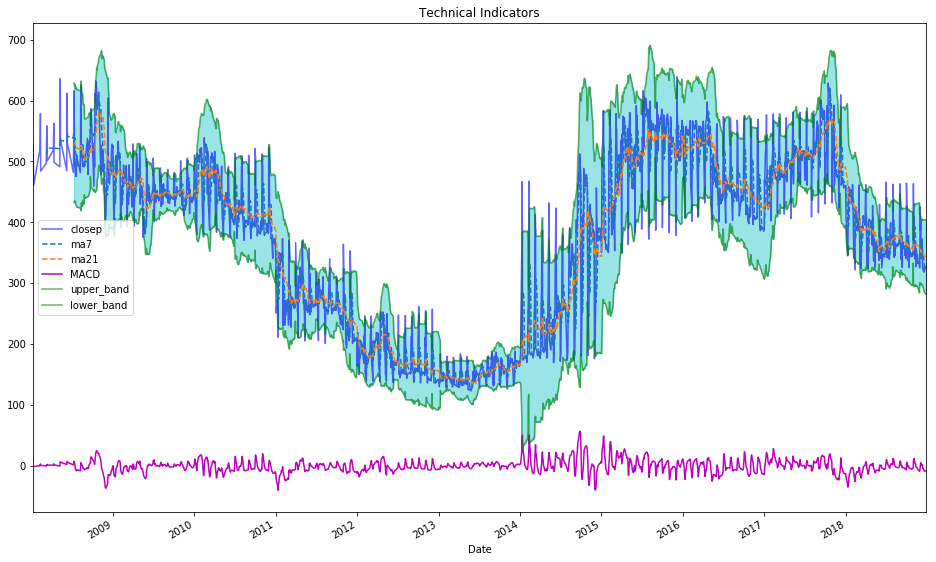

In [10]:
technical_indicators_df = get_technical_indicators(company_data)
plot_technical_indicators(technical_indicators_df)

In [11]:
FEATURES = ["closep", "volume"]
def get_X_y(df, shift=True):
    if shift:
        df_original = df[:-PREDICTION_WINDOW].copy()
        df_new = company_data.copy().shift(-PREDICTION_WINDOW)
        df_new.dropna(inplace=True)
        X = df_original[FEATURES]
        y = df_new[["closep"]]
    else:
        X = df[FEATURES]
        y = df[["closep"]]
    return X, y

In [12]:
def scale_data(data):
    scaler = MinMaxScaler()
    return scaler, scaler.fit_transform(data)

In [33]:
def plot_graph(data, X_predictions, y_predictions, model):
    plt.rcParams["figure.figsize"][0] = 15
    plt.rcParams["figure.figsize"][1] = 5
    sns.lineplot(company_data[-300:].index, company_data[-300:]["closep"])
    sns.lineplot(X_predictions_index, y_predictions.flatten())
    plt.legend(["Actual", "Prediction"])
    plt.autoscale(axis="x", tight=True)
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.xticks(rotation=70)
    plt.title(model.replace("_", " ").title())
    plt.savefig(f"{model}.png")

0.7466653445191369


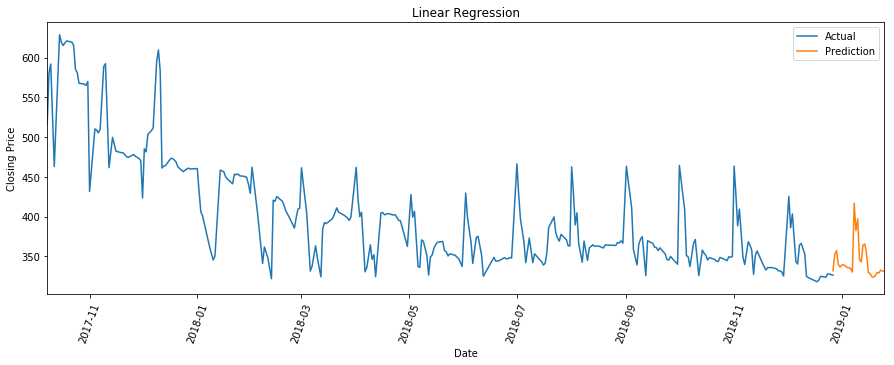

In [34]:
PREDICTION_WINDOW = 30 # predict 30 days into the future

X, y = get_X_y(company_data)
X_scaler, X = scale_data(X)
y_scaler, y = scale_data(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
X_predictions_index = pd.date_range(start=company_data.index[-1], periods=PREDICTION_WINDOW, freq="D")
X_predictions = X_scaler.transform(company_data[-PREDICTION_WINDOW:][["closep", "volume"]])
y_predictions = model.predict(X_predictions)
y_predictions = y_scaler.inverse_transform(y_predictions)
plot_graph(company_data, X_predictions, y_predictions, "linear_regression")
print(score)

In [51]:
def create_in_out_sequences(X, y, tw, pw):
    in_out_seq = []
    L = len(X)
    for i in range(L-tw-pw):
        train_seq = X[i:i+tw]
        train_label = y[i+tw:i+tw+pw]
        in_out_seq.append((train_seq, train_label))
    return in_out_seq

In [52]:
X, y = get_X_y(company_data, shift=False)
X_scaler, X = scale_data(X)
y_scaler, y = scale_data(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensors = torch.FloatTensor(X_train[:, 0]).view(-1)
y_train_tensors = torch.FloatTensor(y_train).view(-1)
X_test_tensors = torch.FloatTensor(X_test[:, 0]).view(-1)
y_test_tensors = torch.FloatTensor(y_test).view(-1)
train_in_out_seq = create_in_out_sequences(X_train_tensors, y_train_tensors, PREDICTION_WINDOW, PREDICTION_WINDOW)

In [53]:
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=100, batch_size=1, output_dim=30, num_layers=1):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers).cuda()
        self.linear = nn.Linear(self.hidden_dim, output_dim).cuda()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input_seq):
        lstm_out, self.hidden = self.lstm(input_seq.view(len(input_seq), self.batch_size, -1))
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

In [58]:
model = LSTM()
model.cuda()
loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 15
loss_values = []

for i in range(epochs):
    for seq, labels in train_in_out_seq:
        optimizer.zero_grad()
        model.hidden = model.init_hidden()

        y_pred = model(seq.cuda())

        single_loss = loss_function(y_pred.cuda(), labels.cuda())
        single_loss.backward()
        optimizer.step()
        
    loss_values.append(single_loss.item())

    print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")

print(f"epoch: {i:3} loss: {single_loss.item():10.10f}")

epoch:   0 loss: 0.11447347
epoch:   1 loss: 0.09952141
epoch:   2 loss: 0.08690210
epoch:   3 loss: 0.07618948
epoch:   4 loss: 0.06711497
epoch:   5 loss: 0.05950551
epoch:   6 loss: 0.05324187
epoch:   7 loss: 0.04822703
epoch:   8 loss: 0.04436197
epoch:   9 loss: 0.04152971
epoch:  10 loss: 0.03958959
epoch:  11 loss: 0.03838189
epoch:  12 loss: 0.03774018
epoch:  13 loss: 0.03750647
epoch:  14 loss: 0.03754360
epoch:  14 loss: 0.0375435986


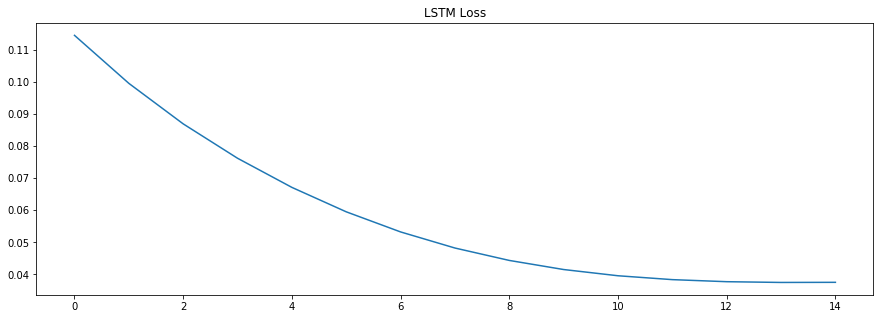

In [59]:
sns.lineplot(x=range(len(loss_values)), y=loss_values)
plt.title("LSTM Loss")
plt.savefig("lstm_loss.png")

In [60]:
model.eval()

accuracies = []
for i in np.arange(0, len(y_test), PREDICTION_WINDOW):
    if len(y_test[i:i+PREDICTION_WINDOW]) == PREDICTION_WINDOW:
        with torch.no_grad():
            model.hidden = model.init_hidden()
            y_test_preds = model(y_test_tensors[i:i+PREDICTION_WINDOW].cuda())
        accuracies.append(r2_score(y_test[i:i+PREDICTION_WINDOW], y_test_preds.cpu()))
        
print(np.average(accuracies))

seq = torch.FloatTensor(X_predictions[:, 0])
with torch.no_grad():
    model.hidden = model.init_hidden()
    y_predictions = model(seq.cuda())
    
y_predictions = y_scaler.inverse_transform(y_predictions.cpu().reshape((len(y_predictions), 1)))

-0.11892472509504308


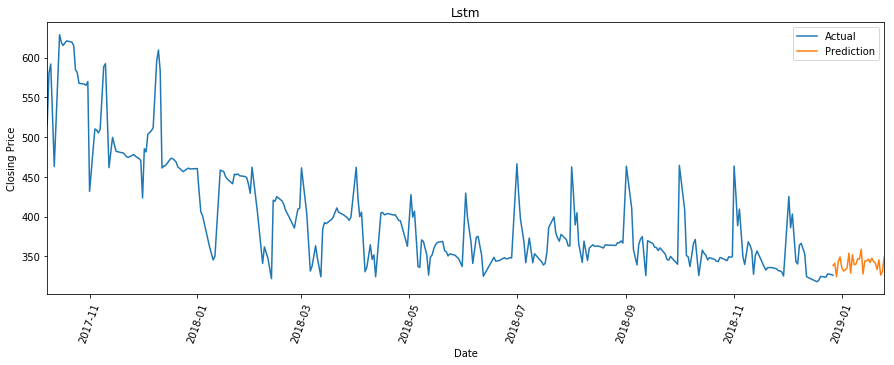

In [61]:
plot_graph(company_data, X_predictions, y_predictions, "lstm")